In [2]:
# import statements including namaster python wrapper
import numpy as np
import healpy as hp
import os
import pymaster as nmt
import pysm3
import pysm3.units as u
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import warnings
warnings.filterwarnings("ignore")

In [6]:
beta_vals = np.arange(0.01,0.2,0.01)

In [3]:
for i, beta in enumerate(beta_vals):
    rand512=np.random.randn(3145728)
    d2p2_fwhm = hp.sphtfunc.smoothing(rand512,fwhm=0.01745)
    d2p2 = d2p2_fwhm*(beta/np.std(d2p2_fwhm))+1.59
    hp.fitsfunc.write_map("beta_mean1p59_std0p0"+str(i+1)+".fits",d2p2)

In [4]:
# read in a planck mask, lower resolution, and apodize it on a scale of ~3 degrees
# HEALPix resolution parameter
nside = 128
# initialize binning scheme with 12 ells per bandpower
b = nmt.NmtBin.from_nside_linear(nside, 12)
# read planck mask (GAL070) and lower resolution to nside=128
mask = hp.read_map("HFI_Mask_GalPlane-apo0_2048_R2.00.fits", field=3)
mask_128 = hp.pixelfunc.ud_grade(mask, 128)
# read mask and apodize it on a scale of ~3degs
mask = nmt.mask_apodization(hp.read_map("mask_GAL070_128.fits", verbose=False), 3., apotype="Smooth")

# function that takes in a frequency and returns map using pysm
def make_map_pysm(freq):
    return dust.get_emission(freq * u.GHz)
# function that take in a map, the map_217, the clbb1x1 value, and the map 217 field and outputs rbb80 value 
def rbb80(map_nu2, clbb1x1, f2_map_nu1, mask):
    # initialize spin-2 field for map2
    f2_map_nu2 = nmt.NmtField(mask, map_nu2, purify_b = True)
    clbb1x2 = nmt.compute_full_master(f2_map_nu1, f2_map_nu2, b)[3][6]
    clbb2x2 = nmt.compute_full_master(f2_map_nu2, f2_map_nu2, b)[3][6]
    return clbb1x2/(np.sqrt(clbb1x1*clbb2x2))

In [5]:
freqs = np.arange(150,3000,150)
rbb80_vals = np.ones((len(freqs),20))*1.
# HEALPix resolution parameter
nside = 128
# initialize binning scheme with 10 ells per bandpower
b = nmt.NmtBin.from_nside_linear(nside, 12)
os.environ["PYSM_LOCAL_DATA"] = os.getcwd()

# for all of the beta values
for i, beta in enumerate(beta_vals):
    dust = pysm3.ModifiedBlackBody(
        nside = 128,
        map_I = "pysm_2/dust_t_new.fits",
        map_Q = "pysm_2/dust_q_new.fits",
        map_U = "pysm_2/dust_u_new.fits",
        unit_I = "uK_RJ",
        unit_Q = "uK_RJ",
        unit_U = "uK_RJ",
        map_mbb_index = "beta_mean1p59_std0p0"+str(i+1)+".fits",
        map_mbb_temperature = "pysm_2/dust_temp.fits",
        unit_mbb_temperature = "K",
        freq_ref_I = "545 GHz",
        freq_ref_P = "353 GHz"
    )
    # make 217GHz map
    map_217GHz = dust.get_emission(217 * u.GHz)
    # initialize a spin-2 field for BB & EE and a spin-0 field for TT, compute their cl80 values
    f2_map_nu1_bb = nmt.NmtField(mask, map_217GHz[1:,:], purify_b = True)
    clbb1x1 = nmt.compute_full_master(f2_map_nu1_bb, f2_map_nu1_bb, b)[3][6]
    
    # compute Rl[80] for every 150GHz from 150GHz to 3THz
    for j, freq in enumerate(freqs):
        map_freq = make_map_pysm(freq)
        rbb80_vals[j][i] = (1 - rbb80(map_freq[1:,:], clbb1x1, f2_map_nu1_bb, mask))

np.savetxt("rbb80_vals217_d2p2.txt", rbb80_vals)


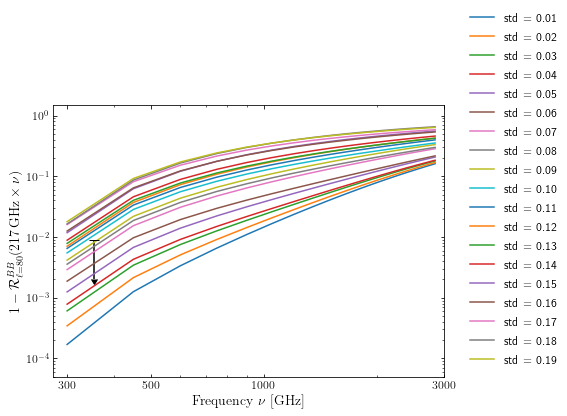

In [12]:
# matplotlib formatting
rc('text', usetex=True)
res_dpi = 300
ext = 'pdf'

fig, ax = plt.subplots(1,1,figsize=(7, 5))
ax.set_xscale('log')
ax.set_xlabel(r'${\rm Frequency}\ \nu\ [{\rm GHz}]$', fontsize=14)
ax.set_yscale('log')
ax.set_ylabel(r'$1 - \mathcal{R}^{BB}_{\ell=80} (217\,{\rm GHz}\times\nu)$', fontsize=14)
ax.axis([275, 3000.,  0.00005, 1.5])
ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis='both', which='both', labelsize=12, bottom=True, top=True, left=True, right=True, direction='in')
ax.set_xticks([300, 500, 1000, 3000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.errorbar([353], [1-0.991], yerr=[.007], uplims = True, color = 'k', marker='_', markersize=10)

rbb80_vals_2 = np.loadtxt('rbb80_vals217_d2p2.txt', usecols=range(20))
for i, beta in enumerate(beta_vals):
    if i<9:
        ax.plot(freqs[1:], rbb80_vals_2[1:,i], label= 'std = 0.0'+str(i+1))
    else:
        ax.plot(freqs[1:], rbb80_vals_2[1:,i], label= 'std = 0.'+str(i+1))

ax.legend(frameon=False, prop={'size': 12}, loc = 'lower left', bbox_to_anchor=(1.04,0))

plt.savefig('max_std.' + ext,format=ext,dpi=res_dpi,bbox_inches='tight')